# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [93]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())
        # this identifies the percentage of the data that is in ANY way toxic = 0.1016 meaning roughly 10% 

    # vectorize Bag of Words from review text; as sparse matrix
    hv = HashingVectorizer(n_features=2 ** 19, alternate_sign=False)
    #n_features controls the num of features. sometimes more is better, sometimes its worse. try it out.
    X_hv = hv.fit_transform(toxic_data.comment_text)
    print("Shape of HashingVectorizer X:")
    print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    #calculates frequencies then divides it by inverse so it calculates weight
    transformer = TfidfTransformer()
    X_tfidf = transformer.fit_transform(X_hv)
    
    # create additional quantitative features
    # SEE HOW THIS AFFECTS THE DATA BY TRYING IT WITH AND WITHOUT
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    sc = StandardScaler(with_mean=False)
    X = sc.fit_transform(X_matrix)
    print(X.shape)
    if (not test):
        y = toxic_data['any_toxic']
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
         #the raw shape meaning without the bag of words and hashing vectorizer
        print(X_raw_train.shape) 
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [94]:
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='toxiccomments_train.csv', my_random_seed=23)

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [13]:
# from sklearn import linear_model
# ols = linear_model.SGDClassifier(loss="squared_loss")
# ols.fit(X_train, y_train)

# ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
# ols_performance_train.compute_measures()
# print(ols_performance_train.performance_measures)

{'Pos': 12945, 'Neg': 114711, 'TP': 5677, 'TN': 60951, 'FP': 53760, 'FN': 7268, 'Accuracy': 0.5219339474838629, 'Precision': 0.09551289600753739, 'Recall': 0.4385477018153727, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [159]:
from sklearn import linear_model
svm = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=0.001,max_iter=10000, shuffle=True, average=150, n_iter_no_change=5, class_weight='balanced')
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12945, 'Neg': 114711, 'TP': 12928, 'TN': 110528, 'FP': 4183, 'FN': 17, 'Accuracy': 0.9670990787742056, 'Precision': 0.7555373736193092, 'Recall': 0.9986867516415604, 'desc': 'svm_train'}


### MODEL: logistic regression

In [156]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log', penalty='l2', alpha=0.00001, max_iter=10000, shuffle=True, average=150, n_iter_no_change=5, class_weight='balanced')
#i added a really low alpha value to increase generalization, and saw that when i added the average the recall increased
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 12945, 'Neg': 114711, 'TP': 12923, 'TN': 111041, 'FP': 3670, 'FN': 22, 'Accuracy': 0.9710785235319922, 'Precision': 0.7788223949858374, 'Recall': 0.9983005021243724, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [133]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB(alpha=0.0001, fit_prior=False, class_prior=None)
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 12945, 'Neg': 114711, 'TP': 12783, 'TN': 103833, 'FP': 10878, 'FN': 162, 'Accuracy': 0.9135175784921978, 'Precision': 0.5402561176619755, 'Recall': 0.9874855156431055, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [134]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 12945, 'Neg': 114711, 'TP': 12836, 'TN': 114612, 'FP': 99, 'FN': 109, 'Accuracy': 0.9983706210440559, 'Precision': 0.9923463471202165, 'Recall': 0.9915797605252994, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [145]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=0.0001, fit_intercept=True, normalize=False, copy_X=True, max_iter=1000, tol=0.001)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12945, 'Neg': 114711, 'TP': 10775, 'TN': 114582, 'FP': 129, 'FN': 2170, 'Accuracy': 0.981990662405214, 'Precision': 0.9881694790902421, 'Recall': 0.8323677095403631, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [153]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(n_estimators=10, criterion='entropy', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 12945, 'Neg': 114711, 'TP': 11848, 'TN': 114701, 'FP': 10, 'FN': 1097, 'Accuracy': 0.9913282571912013, 'Precision': 0.9991566874683758, 'Recall': 0.9152568559289301, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

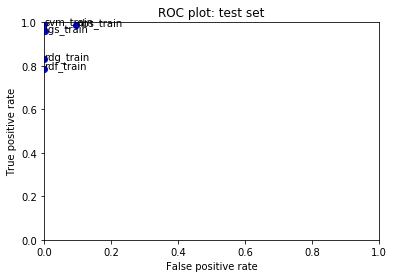

In [151]:
fits = [svm_performance_train, lgs_performance_train, nbs_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

nbs_predictions = nbs.predict(X_train)

### let's look at some false positives:

In [73]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(nbs_predictions)):  #when uploading to github, make the length shorter than the entire list
    if (nbs_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 10% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
296
from Iran) like Indian-American.
* * * * * * * * * 
519
Vandalism? 
I have traced this IP 
http://en.wikipedia.org/wiki/User_talk:78.55.58.71 but I had not found the slightest hint on vandalism. Why do you block users on false reasons?  92.230.85.188
* * * * * * * * * 
773
Do not be a vandal to the Malta page. 

Or I will report you to wikipedia!
* * * * * * * * * 
786
The Hate ==
Why all the hate???

== Re:
* * * * * * * * * 
843
this is my sandbox, where i wil be testing out stuff. 

stuff i forget 

templates don't have to be written wit templates in them
use  and  to place examples of markup here
* * * * * * * * * 
999
Deletionist! 

Geogre, face it buddy, you're a deletionist and there is nothing more to it.

Happy deleting!
* * * * * * * * * 
1012
POV on God entry 

Thank you for pointing out as such; I'm admittedly late to the conversation, and was hesitant to make the reversion. There are too many people who want to push their own lack of religi

12424
You need to find sources that state what you are claiming.  waits for audience applause, not a sausage
* * * * * * * * * 
12473
Typical Arab imperialist. Aren't you tired of making up lies?
* * * * * * * * * 
12693
What do you expect me to do???? I have been blocked indef and can't edit.
* * * * * * * * * 
12792
any chance 

you can fix this? pretty much no one seems to care enough to respond. i finally managed to get mel etitis to look, but he said there's no block. i can assure you that there is. as i understand it, no one will at ANU will be able to create (or possibly use) an account until
* * * * * * * * * 
12864
You're Right 

But I had to let them know that i'm not having it. I provided a source for Castle Walls and the girl reverted it without even looking. So yes it made me a liitle angry, but I didn't mean no harm. I hope I won't be blocked for speaking my peace.
* * * * * * * * * 
13137
Hey whats going on here? Surely you guys aren't picking on a kid with down syndrom,

24714
No idea what you are talking about
* * * * * * * * * 
25275
Agreed.  If we can come up with any verifiable information as to why, then we should put it back.  Until then, I think the section works pretty well - thanks!   Chancemichaels
* * * * * * * * * 
25378
area

All nude pics removed
No need for anymore complaints about nude pics. I removed them all. User: Coconutfred73 9:45 6 June 2006 (UTC)
* * * * * * * * * 
25597
i know i do and you like it
* * * * * * * * * 
25807
im new to this so I really don't know what im doing do anybody want to help??????????????
* * * * * * * * * 
26390
Hi, this is an encyclopedia, and it's not for joking around.  You might like www.uncyclopedia.org instead.  Thanks,  (talk)
* * * * * * * * * 
26499
Get bent fagot. 109.123.123.36
* * * * * * * * * 
26680
Censorship 

Why not refute the facts instead of censorship? I believe you sir are the violator of NPOV, and worse, by abusing editor privileges you continue to undermine the goals of Wikipedia.
*

41651
What exactly does Ryulong's last edit on my talk page have to do with the encyclopedia. The issue was over, I said that I would not contact him again and he leaves and aggressive comment on my talk page starting it again. How can you justify attacking my comments but not his. Just because he edits more than me? That gives him the right to make rude comments towards me, about a subject that I said I had dropped?
* * * * * * * * * 
42237
i thought tht tha g unit feud page was kool,y did it get removed? -
* * * * * * * * * 
42250
but what if i am gay 

i need to know
* * * * * * * * * 
42395
Please stop.  If you are going to make accusatory statements about a living person in an article, please be sure to WP:CITE verifiable and reliable sources when doing so.  Thanks.
* * * * * * * * * 
42432
" | decline=You do that, I'm sure lots of people are happy to waste their lives and die virgins  Talk "
* * * * * * * * * 
43005
"auto|1=65.242.111.254|2=Autoblocked because your IP address was

53775
Grow up little man, its rather pathetic you sit here trying to use Wikipedia for political attacks.
* * * * * * * * * 
54083
- both in regards of the BNP/fascism-issue
* * * * * * * * * 
54498
"

Oh you'l come back, ive had so really really hard times here recently but i stayed.  ('Come Speak To Me') "
* * * * * * * * * 
54621
The standard offer 

User:Tokyogirl79
What to do for The standard offer?
* * * * * * * * * 
54849
War Games 

I'm not happy about the way that you make war games for just adults. I think that you could make more war games that are for adults but you could also make a child's version of them. It would be great for children to not get jealous of their parents because they are playing the game and not them. I'm sure lots of children would like to buy the games if they were suitable for them.
* * * * * * * * * 
55139
It was, just an edit conflict. I already responded to Jclemens about it. Thanks.
* * * * * * * * * 
55367
And you didn't answer my question. Mabyb

65003
There's history with me and the other editor that goes way beyond Wikipedia, which is why I can't take him at his word.  But nonetheless I went too far and got spanked, which I probably had coming.  Lesson learned  I'll put my money where my mouth is....If I ever do it again, you can give me a lifetime ban...finito, see ya bye.  I'm willing to stick my neck out if you're willing me work with me.  (talk)
* * * * * * * * * 
65029
"

Thanks! Done again, I think. The septic system assumption is correct, but I was unsure how exactly to spell that out since the source says ""44% have sewerage system connections"" and ""public sewerage systems and septic tank systems are in use"".  "
* * * * * * * * * 
65349
Well, at least now we know you are neither an honest nor truthful person. But, then, I suspect you already know that.
* * * * * * * * * 
65486
If only I could somehow get a new IP address. Sigh. I guess I'll just have to continue being blocked from your retarded encyclopedia.
* * * 

77850
"

I am the person who made the page about ""the online community about a strip in a newspaper""

If Ebaum can have a page, so can we. If the vagina can have a page, so can we. If Numa frigging Numa can have a page, so can we.

The page is well written and is doing no harm, so why not leave it alone, eh?"
* * * * * * * * * 
78136
I will add references later if I add references will  you stop undoing all of the hard work I put in to post the wealth of knowledge I posted? will that make you happy and make you stop defacing/vandalizing my content? I am fully aware on can merely request a references within the content itself I know the feature exists that and the original content you keep reverting my content to also has no references that tell me you are reverting my content for another reason reason you are not admitting that is to say censorship in which it is absolutely vandalism and defacement if you really do want me to add references or anyone else to add references although s

90047
What a good laugh...
* * * * * * * * * 
90124
Anti-Arab 

Thanks for talking to me. For reasons, see the discussion page.
* * * * * * * * * 
90248
Your user name 

LOL.
* * * * * * * * * 
90820
It's a good thing we, as a society, came to our senses about the real sickness.  You can go back to molesting some kids now.
* * * * * * * * * 
91032
Take it easy Dennis Brown, someone just hacked into my wikipedia account and is writing all this stuff, Im going to change my password so he doesn't get in again. 26 April
* * * * * * * * * 
91195
Thank you for notifying me, but there seems to be no need to respond there. Woodzing likes his own photos a bit too much. Regards, /
* * * * * * * * * 
91294
|Miss Ciara]] 15:52, 8 June 2006
* * * * * * * * * 
91315
Please 

Escape this place while you can. Don't end up like me. Having nightmares about this place. I keep on thinking it will completely go away, but it doesn't.
* * * * * * * * * 
91542
"
How are those homeless people coming along? Nic

107793
"

 A barnstar for you! 

  The Special Barnstar Retired? Why? my friend? OMG you are one of the most productive user on Wikipedia! Please reconsider. You will be missed '-( Jim Carter "
* * * * * * * * * 
107811
This is an interesting topic.  It seems like Aramaic was more widely understood by the populace than Hebrew by that time, but I guess the obvious question researchers probably look at is, what kind of things were written in Aramaic at that time, and what kind of things were still being written in Hebrew?   /talk/
* * * * * * * * * 
107866
. And don't think about reverting my edits because I'll revert it back.
* * * * * * * * * 
108004
Comment from user page 

Thank you for your reply. I am still finding Wiki difficult to edit.
The article I posted was researched. I made a four hour journey to the Newspaper museum in Collindale. Then my article was removed without any notification to me!
* * * * * * * * * 
108621
tha's right perfectly civil...
* * * * * * * * * 
108622
W

121316
3RR 

You've been blocked for 24 hours per the above.      धर्म
* * * * * * * * * 
121434
How am I a vandal? 

Can you explain what have I done that you call vandalism? It's easy to bully people when you have powers.
* * * * * * * * * 
121635
REDIRECT Talk:Jo's Boys (anime)
* * * * * * * * * 
122300
Yo - Don't be vandalizing pages.
* * * * * * * * * 
122530
"

 Incivility/No personal attacks 

Edit summaries like this are highly innappropriate. Please read WP:CIVIL and No personal attacks. You've already been warned about vandalism. Please stop your disruptive editing, or you'll be blocked. Thanks.  msg me  "
* * * * * * * * * 
122615
I honostly don't believe that this article needs any more work. The organization can be better but I know nothing of Jerry and I'm not his fan.
* * * * * * * * * 
122881
To whom ever the hell you are;

Greg Thomas is Gay. This is Fact. I have seen him with other men and have photo and video evidence to prove it sir. If you must warn anyone, warn
th

In [163]:
lgs_predictions = lgs.predict(X_train)
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(lgs_predictions)):  #when uploading to github, make the length shorter than the entire list
    if (lgs_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')



Examples of false positives:
1661
You really are something else. 

You know that? Why you and administrators continue to insist on thinking that I'm Fragments of Jade or whatever name that woman uses is still a mystery to me. You want to believe I'm female? Be my guest. You want to have me range blocked? Be my guest. You want to continue to believe that I'm Fragments of Jade/Yomiel or whatever username that woman uses? Be my guest. It won't change the fact that you're blocking the wrong person. You, the administrators and Fragments of JadeYomiel have made my life a living hell. I knew I should have stayed the hell away from you. Now I know how innocent people feel when they go to prison. Go ahead. Have me range blocked. Block an innocent person if it make you sleep at night. Over and out. 68.45.60.20
* * * * * * * * * 
2248
"Suggest PL, that you focus on your ""own"" behavior on the Wiki-Nostradamus Page, and cease with the high school attitude that attempts to divert attention from yo

28105
, pompous and abusing the little authority I have, I enjoy my same sex
* * * * * * * * * 
29463
"

Ok, I don't ""proudly"" use a swear on my page, it's true I do know a shitload of info for my age (I'm not telling you). I was also annoyed how some users, like you for example, is so uptight about the rules, it's like ""Come'on give it a rest already. Finally, just because I use a swear does not make all aussie ""blokes"" complete obnoxious people who swear every minute. And you've got the wrong idea of civility. That's all I have to say. "
* * * * * * * * * 
29546
whatever, time has come for me to stop wasting my time trying to educate ungrateful foreign kids.
* * * * * * * * * 
30849
Help! Help me perform Autofellatio!
* * * * * * * * * 
31117
You've got problems.  You are vandalising the article by removing improvements.  Grow up and get over whatever it is you need to get over.
* * * * * * * * * 
31299
"

I have never heard of this ""other"" Jon Favreau. If you think that he is

51925
What are you Talking about?
* * * * * * * * * 
52676
Please no Wiki-Weirdo posts !
* * * * * * * * * 
53092
Keep up your little attack Propol, and we'll keep editing everything you do.  Grow up little man, and move out of your parent's basement.
* * * * * * * * * 
53213
"

 I Don't Recall You Ever Getting Anyone 2.1 Million Dollars* 

 How can you say that this person doesn't mean anything?  ""Ye who is without sin may cast the first stone!""  Larry H. Parker is a living legend!  He fights for the rights of the innocent!  Perhaps you do not like him because you yourself have been the perpitraitor of such malicious acts in which you may have got away scot-free had it not been for a crusader for the people such as Larry H. Parker!  Do you have a law firm?  Have you ever made a commercial?  Have you ever fought for victim's rights?  I don't think so!  Look within yourself before you denegrate such a noble individual.   
 *over the course of a life time "
* * * * * * * * * 
53467
So 

70790
You're a meme on 4chan's /b/ imageboard now! LOL
* * * * * * * * * 
71036
{{unblock|The reason I used sockpuppets was to avoid harassment from user: Dibo who immediately reverted all my edits, ,  and  when I forgot to log and branded me a sockpuppet of some previous user, here  which the checkuser proved did not exist . I got into a revert war with user: Tancred and user: Dibo who from the contributions, seemed to devote their time exclusively to making trouble and aiding each other in edit wars, as is shown here, ,  as well as in the earlier case regarding user: Ehinger222 who they erroneeouslly accused me of being. After several days of edit warring with user: Tancred over the right to call rugby league football, football,(surely a neccessity and not erroneous), user: Tancred's vandalism to the rugby league nations template here , The names of various sports on the Marconi stadium site  and whether the a-league franchises should be referred to as clubs(part of their franchise n

100750
You sodomites really know how to stick together....yech !!!! anyhow, tomorrow is another day. furthermore, i rotate ip addresses about every 2-3 days........Keep on Suckin'  —Preceding unsigned comment added by 97.88.222.103
* * * * * * * * * 
100861
":::I was going to make it darker, but then my sig didn't show up. So I'll probably change my signature too, just give me a sec,  (Talk to me, or I'll eat your liver!) 

"
* * * * * * * * * 
101032
It would be amazing if you killed yourself.
* * * * * * * * * 
102002
Yes, I had already read a more detailed account of what happened, but thought that these details are better located in the article on the history of Romania. Also, again, what I wrote doesn't seem to conflict with what you wrote ie Romania surrendered, but didn't ratify the Peace Treaty. After all, the US never ratified the Treaty of Trianon, but this doesn't mean that the treaty wasn't valid.  11:58, 14 Nov 2004 (UTC)
* * * * * * * * * 
102721
TRUE, BUT YOU CAN'T PROVE

In [128]:
svm_predictions = svm.predict(X_train)
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(svm_predictions)):  #when uploading to github, make the length shorter than the entire list
    if (svm_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.1): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')

#It may be that its using all caps and profuse use of punctuation is being learned as toxic
#i would like to re-iterate that some of the trained data is mis-labelled or bias!

Examples of false positives:
14614
Strong Support - Sad to see antisemitic opposing views.
* * * * * * * * * 
18412
I sincerely wish i could meet you chumps   
    
You freaks really get my goat. Etaonsh(still stuck in 1940's Europe), Firestar(firststatr Kung Fu extraordinaire), COvenantD(typical east coast jerk), Mibhofroovvsskskkety(russkie man frozen in USSR), Samuel Luo(weird lookin crazy), and crazy ol' Tomanandaaa!(brokeback mt.! u give w.hollywood a bad name!) Hey tom, when are you going to make a real citation? your scholarship is the worst i have ever seen. stay in your hole in the public library, transient!   
    
    
We know you have no lives and are failures, I really can't believe how much you guys are on this site. I have been away for awhile(thanks to some good old censorship courtesy of that advocate of free speech, Fristare, kung fu chump) but you have been here night and day it appears. It's like you are writing books on the Falun Gong page alone. Freaks!   
    
Ge

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [15]:
# ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
# ols_performance_test.compute_measures()
# print(ols_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 1509, 'TN': 14636, 'FP': 14061, 'FN': 1709, 'Accuracy': 0.505874980416732, 'Precision': 0.09691714836223507, 'Recall': 0.4689247980111871, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [160]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3280, 'Neg': 28635, 'TP': 2654, 'TN': 25692, 'FP': 2943, 'FN': 626, 'Accuracy': 0.8881717060943131, 'Precision': 0.47418259782026084, 'Recall': 0.8091463414634147, 'desc': 'svm_test'}


### MODEL: logistic regression

In [157]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3280, 'Neg': 28635, 'TP': 2613, 'TN': 25790, 'FP': 2845, 'FN': 667, 'Accuracy': 0.8899577001409995, 'Precision': 0.47874679369732503, 'Recall': 0.7966463414634146, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [140]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3280, 'Neg': 28635, 'TP': 2105, 'TN': 23320, 'FP': 5315, 'FN': 1175, 'Accuracy': 0.7966473445088517, 'Precision': 0.28369272237196763, 'Recall': 0.6417682926829268, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [141]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3280, 'Neg': 28635, 'TP': 2112, 'TN': 27155, 'FP': 1480, 'FN': 1168, 'Accuracy': 0.9170296099013003, 'Precision': 0.5879732739420935, 'Recall': 0.6439024390243903, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [154]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3280, 'Neg': 28635, 'TP': 1666, 'TN': 28482, 'FP': 153, 'FN': 1614, 'Accuracy': 0.9446341845527182, 'Precision': 0.9158878504672897, 'Recall': 0.5079268292682927, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [155]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3280, 'Neg': 28635, 'TP': 989, 'TN': 28585, 'FP': 50, 'FN': 2291, 'Accuracy': 0.9266489111702961, 'Precision': 0.9518768046198267, 'Recall': 0.30152439024390243, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

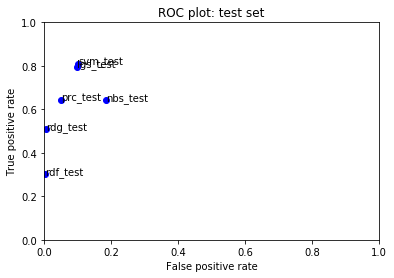

In [161]:
fits = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [165]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='toxiccomments_test.csv', my_random_seed=23, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 524288)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0          72          10
1          13           1
2          16           0
3          38           3
4           7           1
5          16           2
6          31           4
7           6       

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [172]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = svm.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.25279439032670864


In [173]:
raw_data.head()

,id,comment_text,word_count,punc_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1


In [175]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [176]:
my_submission.shape

(153164, 2)

In [177]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation